In [41]:
## P1 - Parte Computacional - PSI3471
## Aluno: Leonardo Isao Komura - NUSP: 11261656

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [43]:
# Leitura dos arquivos
ecg_treino = pd.read_pickle("ecg_treino.pickle")
rotulos_treino = pd.read_csv("rotulos_treino.csv")
n_rotulos_treino = pd.read_csv("n_rotulos_treino.csv")  

ecg_teste = pd.read_pickle("ecg_teste.pickle")
rotulos_teste = pd.read_csv("rotulos_teste.csv")
n_rotulos_teste = pd.read_csv("n_rotulos_teste.csv") 

In [44]:
# Transformação em formato numpy
treino = ecg_treino.to_numpy()
r_treino = rotulos_treino.to_numpy()
n_treino = n_rotulos_treino.to_numpy()

teste = ecg_teste.to_numpy()
r_teste = rotulos_teste.to_numpy()
n_teste = n_rotulos_teste.to_numpy()

In [45]:
# Deletando os "nomes" dos pacientes
treino = np.delete(treino, 0, axis=1)
r_treino = np.delete(r_treino, 0, axis=1)
n_treino = np.delete(n_treino, 0, axis=1)

teste = np.delete(teste, 0, axis=1)
r_teste = np.delete(r_teste, 0, axis=1)
n_teste = np.delete(n_teste, 0, axis=1)

print(treino)

[[-0.345 -0.345 -0.345 ... -0.295 -0.29 0.0]
 [-0.31 -0.31 -0.31 ... 0.635 0.265 0.0]
 [-0.125 -0.125 -0.125 ... -0.01 0.04 0.0]
 ...
 [-0.69 -0.69 -0.69 ... -0.16 -0.155 0.0]
 [-0.93 -0.93 -0.93 ... -0.55 -0.555 0.0]
 [-0.38 -0.38 -0.38 ... -0.59 -0.59 0.0]]


In [46]:
# Cálculo da média do "comprimento" dos 1000 primeiros batimentos de todos pacientes
nn = 0.0
for i in range(0, len(n_treino)):
    for j in range(1000):
        nn = nn + abs(n_treino[i,j] - n_treino[i, j+1])
nn_average = math.ceil(nn/(1000*len(n_treino)))
print("Média do comprimento dos 1000 primeiros batimentos de todos pacientes: ", nn_average)

Média do comprimento dos 1000 primeiros batimentos de todos pacientes:  291


In [47]:
# Colocando cada batimento numa posição de um tensor
n_pontos = 400000
batimentos = int(n_pontos/nn_average)
tensor_treino = np.ndarray(shape=(len(treino), batimentos, nn_average), dtype=float)
for i in range(len(treino)):
    for j in range(batimentos):
        tensor_treino[i,j] = np.append(0, np.fft.fft(treino[i, int(n_treino[i,j]) : int(n_treino[i,j+1])], n = nn_average-1))
        
tensor_teste = np.ndarray(shape=(len(teste), batimentos, nn_average), dtype=float)
for i in range(len(teste)):
    for j in range(batimentos):
        tensor_teste[i,j] = np.append(0, np.fft.fft(teste[i, int(n_teste[i,j]) : int(n_teste[i,j+1])], n = nn_average-1))

C:\Users\leona\AppData\Local\Temp\ipykernel_456\1939063734.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  tensor_treino[i,j] = np.append(0, np.fft.fft(treino[i, int(n_treino[i,j]) : int(n_treino[i,j+1])], n = nn_average-1))
C:\Users\leona\AppData\Local\Temp\ipykernel_456\1939063734.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  tensor_teste[i,j] = np.append(0, np.fft.fft(teste[i, int(n_teste[i,j]) : int(n_teste[i,j+1])], n = nn_average-1))


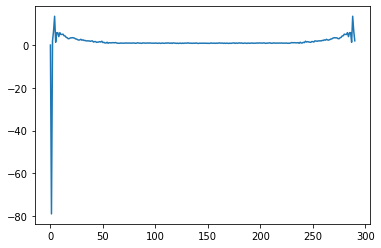

In [48]:
plt.plot(tensor_treino[0,7])

In [49]:
# Cálculo da média do "comprimento" de 3 batimentos
for i in range(len(n_treino)):
    for j in range(batimentos):
        nn = 0.0
        if(j == 0):
            for k in range(3):
                nn = nn + abs(n_treino[i,k] - n_treino[i, k+1])
            nn_average = nn/3
            tensor_treino[i,j,0] = nn_average
        elif(j == batimentos-1):
            for k in range(batimentos-4, batimentos-1):
                nn = nn + abs(n_treino[i,k] - n_treino[i, k+1])
            nn_average = nn/3
            tensor_treino[i,j,0] = nn_average
        else:
            for k in range(3):
                nn = nn + abs(n_treino[i,k+j-1] - n_treino[i, k+j])
            nn_average = nn/3
            tensor_treino[i,j,0] = nn_average
 
for i in range(len(n_teste)):
    for j in range(batimentos):
        nn = 0.0
        if(j == 0):
            for k in range(3):
                nn = nn + abs(n_teste[i,k] - n_teste[i, k+1])
            nn_average = nn/3
            tensor_teste[i,j,0] = nn_average
        elif(j == batimentos-1):
            for k in range(batimentos-4, batimentos-1):
                nn = nn + abs(n_teste[i,k] - n_teste[i, k+1])
            nn_average = nn/3
            tensor_teste[i,j,0] = nn_average
        else:
            for k in range(3):
                nn = nn + abs(n_teste[i,k+j-1] - n_teste[i, k+j])
            nn_average = nn/3
            tensor_teste[i,j,0] = nn_average   

In [50]:
# Transformando um tensor numa matriz (cada linha refere-se a um batimento + media)
matriz_treino = np.zeros((batimentos*len(treino), len(tensor_treino[0,0])))
n = 0
for i in range(len(treino)):
    for j in range(batimentos):
        matriz_treino[n] = tensor_treino[i,j]
        n = n+1

matriz_teste = np.zeros((batimentos*len(teste), len(tensor_teste[0,0])))
n = 0
for i in range(len(teste)):
    for j in range(batimentos):
        matriz_teste[n] = tensor_teste[i,j]
        n = n+1

In [51]:
df_treino = pd.DataFrame(matriz_treino)
df_teste = pd.DataFrame(matriz_teste)

In [52]:
print(df_treino)

              0        1          2          3          4         5    \
0      316.333333  -85.495   1.334420   4.344230  11.853086  1.066591   
1      316.333333  -75.480   1.620813   5.644631  11.253024  1.161649   
2      324.000000  -87.190   3.100443   7.278384  13.681453  2.723566   
3      333.666667 -106.175   2.351918  10.244430  14.573058  4.460593   
4      334.666667  -94.160  -0.279416   8.764485  12.686658  4.655553   
...           ...      ...        ...        ...        ...       ...   
30223  265.333333  -74.765  20.741836  16.503941  17.738175  8.621766   
30224  262.666667  -81.230  24.999851  14.953760  11.818414  3.448767   
30225  260.333333  -77.245  21.823993  10.370354  13.286535 -0.661038   
30226  258.333333  -59.700  21.387182  12.004994  12.114716  0.844712   
30227  260.333333  -57.485  21.319439   6.808718   2.573341 -0.880699   

            6          7          8          9    ...        281        282  \
0      3.353198   4.823946   2.864674   4.28

In [53]:
# Criando a matriz de rótulos binária
matriz_rotulos_treino_2 = np.zeros((batimentos*len(treino),1))
n = 0
for i in range(len(treino)):
    for j in range(batimentos):
        if(r_treino[i,j] == "N"):
            x = 0.0
        else: x = 1.0
        matriz_rotulos_treino_2[n,0] = x
        n = n+1
        
matriz_rotulos_teste_2 = np.zeros((batimentos*len(teste),1))
n = 0
for i in range(len(teste)):
    for j in range(batimentos):
        if(r_treino[i,j] == "N"):
            x = 0.0
        else: x = 1.0
        matriz_rotulos_teste_2[n,0] = x
        n = n+1

In [54]:
df_r_treino_2 = pd.DataFrame(matriz_rotulos_treino_2)
df_r_teste_2 = pd.DataFrame(matriz_rotulos_teste_2)

In [55]:
# Criando a matriz de rótulos multiclasse
matriz_rotulos_treino_m = np.zeros((batimentos*len(treino),1))
n = 0
for i in range(len(treino)):
    for j in range(batimentos):
        if(r_treino[i,j] == "N"):
            x = 1.0
        elif(r_treino[i,j] == "F"): 
            x = 2.0
        elif(r_treino[i,j] == "Q"): 
            x = 3.0
        elif(r_treino[i,j] == "S"): 
            x = 4.0
        elif(r_treino[i,j] == "V"): 
            x = 5.0
        else:
            x = -1.0
        matriz_rotulos_treino_m[n,0] = x
        n = n+1
        
matriz_rotulos_teste_m = np.zeros((batimentos*len(teste),1))
n = 0
for i in range(len(teste)):
    for j in range(batimentos):
        if(r_treino[i,j] == "N"):
            x = 1.0
        elif(r_treino[i,j] == "F"): 
            x = 2.0
        elif(r_treino[i,j] == "Q"): 
            x = 3.0
        elif(r_treino[i,j] == "S"): 
            x = 4.0
        elif(r_treino[i,j] == "V"): 
            x = 5.0
        else:
            x = -1.0
        matriz_rotulos_teste_m[n,0] = x
        n = n+1


In [56]:
df_r_treino_m = pd.DataFrame(matriz_rotulos_treino_m)
df_r_teste_m = pd.DataFrame(matriz_rotulos_teste_m) 

In [57]:
# SMOTE
import imblearn
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
df_treino, df_r_treino_2 = oversample.fit_resample(df_treino, df_r_treino_2)

In [58]:
print(df_r_treino_2)

         0
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
...    ...
54791  1.0
54792  1.0
54793  1.0
54794  1.0
54795  1.0

[54796 rows x 1 columns]


In [59]:
# Validação cruzada
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(df_treino, df_r_treino_2, test_size = 0.1, random_state=9)
print('Qtde de treino: {}'.format(len(x_train)))
print('Qtde de validação: {}'.format(len(x_val)))

Qtde de treino: 49316
Qtde de validação: 5480


In [60]:
# Criando a MLP
model = Sequential()
model.add(Dense(300, activation='elu', input_shape=(len(matriz_treino[0]),)))
model.add(Dropout(0.2))
model.add(Dense(200, activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [61]:
batch_size = 500
epochs = 10
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_val, y_val))

Epoch 1/10
99/99 [==============================] - 3s 20ms/step - loss: 0.8639 - accuracy: 0.6859 - val_loss: 0.3527 - val_accuracy: 0.8619
Epoch 2/10
99/99 [==============================] - 2s 20ms/step - loss: 0.3958 - accuracy: 0.8294 - val_loss: 0.2744 - val_accuracy: 0.8673
Epoch 3/10
99/99 [==============================] - 2s 17ms/step - loss: 0.3079 - accuracy: 0.8741 - val_loss: 0.2112 - val_accuracy: 0.9177
Epoch 4/10
99/99 [==============================] - 2s 19ms/step - loss: 0.2484 - accuracy: 0.9018 - val_loss: 0.1704 - val_accuracy: 0.9316
Epoch 5/10
99/99 [==============================] - 2s 18ms/step - loss: 0.2163 - accuracy: 0.9147 - val_loss: 0.1504 - val_accuracy: 0.9405
Epoch 6/10
99/99 [==============================] - 2s 18ms/step - loss: 0.1821 - accuracy: 0.9294 - val_loss: 0.1240 - val_accuracy: 0.9538
Epoch 7/10
99/99 [==============================] - 2s 17ms/step - loss: 0.1578 - accuracy: 0.9405 - val_loss: 0.1219 - val_accuracy: 0.9522
Epoch 8/10
99

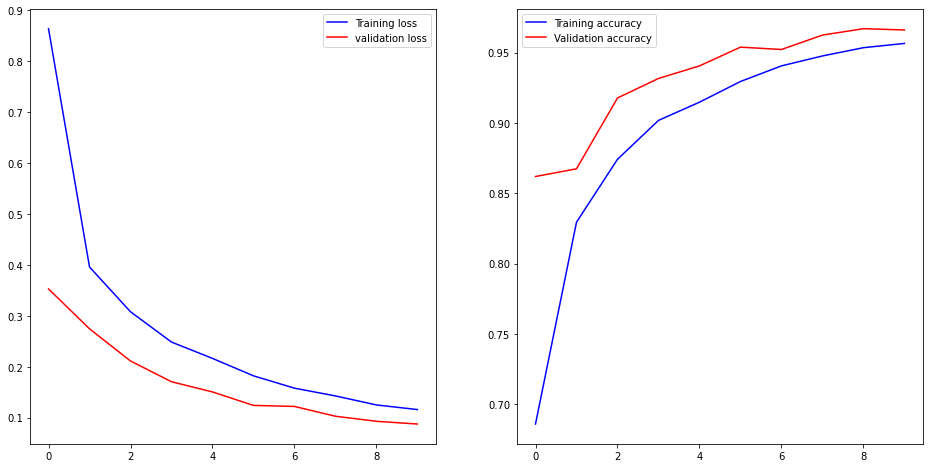

In [62]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=False)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=False)


In [63]:
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

945/945 [==============================] - 2s 2ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.73      0.90      0.81     22352
           1       0.21      0.08      0.11      7876

    accuracy                           0.69     30228
   macro avg       0.47      0.49      0.46     30228
weighted avg       0.60      0.69      0.63     30228



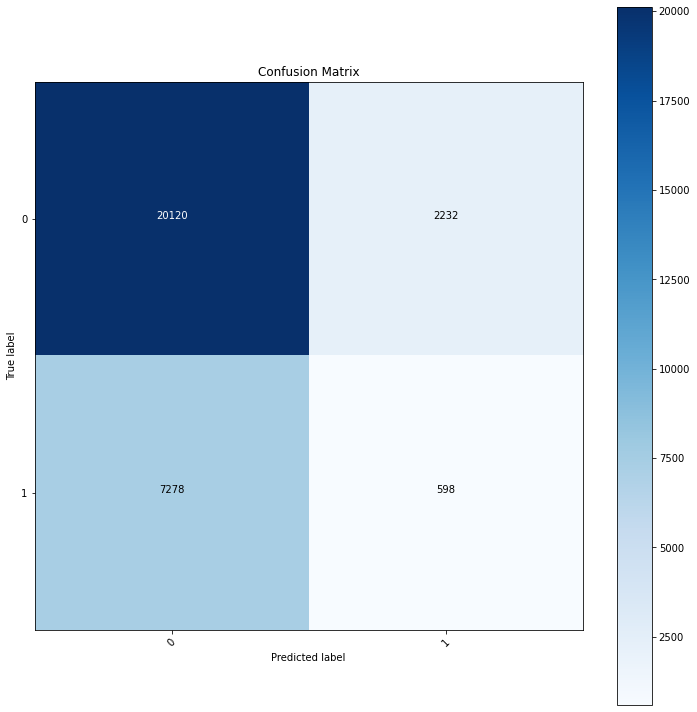

In [64]:
target_names = ['0', '1']
r_teste_2 = (model.predict(df_teste) > 0.5).astype("int32")
cm = confusion_matrix(r_teste_2, df_r_teste_2)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

print('Classification Report')
print(classification_report(r_teste_2, df_r_teste_2, target_names=target_names))
